In [37]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
import os
from os.path import isfile
from pandas import DataFrame

In [38]:
import pandas as pd

optfileList = ['../data/CRex/RHRS/CRex_DataSet_21743.csv',
               '../data/CRex/RHRS/CRex_DataSet_21744.csv',
               '../data/CRex/RHRS/CRex_DataSet_21748.csv',
               '../data/CRex/RHRS/CRex_DataSet_21749.csv',
               '../data/CRex/RHRS/CRex_DataSet_21752.csv',
               '../data/CRex/RHRS/CRex_DataSet_21753.csv',
               '../data/CRex/RHRS/CRex_DataSet_21754.csv',
               '../data/CRex/RHRS/CRex_DataSet_21755.csv',
               '../data/CRex/RHRS/CRex_DataSet_21756.csv',
               '../data/CRex/RHRS/CRex_DataSet_21757.csv',
               '../data/CRex/RHRS/CRex_DataSet_21768.csv',
               '../data/CRex/RHRS/CRex_DataSet_21769.csv',
               '../data/CRex/RHRS/CRex_DataSet_21770.csv',
               '../data/CRex/RHRS/CRex_DataSet_21771.csv',
               '../data/CRex/RHRS/CRex_DataSet_21772.csv',
               '../data/CRex/RHRS/CRex_DataSet_21781.csv',
               '../data/CRex/RHRS/CRex_DataSet_21782.csv',
               '../data/CRex/RHRS/CRex_DataSet_21783.csv',
               '../data/CRex/RHRS/CRex_DataSet_21784.csv',
               '../data/CRex/RHRS/CRex_DataSet_21785.csv',
               ]

# load all the dataset and start the training process
li = []
for file in optfileList:
    if isfile(file):
        df = pd.read_csv(file,index_col=None,header=0)
        li.append(df)
dataInitial = pd.concat(li,axis=0,ignore_index=True)
data = pd.concat(li,axis=0,ignore_index=True)

data

,evtID,runID,CutID,SieveRowID,SieveColID,bpmX,bpmY,focal_x,focal_y,focal_th,focal_ph,targCalTh,targCalPh
0,0,21743,253,1,8,0.000290,-0.001503,-0.301587,0.016011,0.012192,0.000739,-0.029615,-0.006545
1,1,21743,226,2,4,0.000290,-0.001503,-0.037429,-0.007679,0.001400,0.011046,-0.009243,0.008405
2,2,21743,254,2,8,0.000290,-0.001503,-0.283216,0.012550,0.004096,-0.000475,-0.016034,-0.006545
3,3,21743,241,3,6,0.000290,-0.001503,-0.249758,0.006722,-0.003607,0.006061,-0.002452,-0.000295
4,4,21743,243,5,6,0.000290,-0.001503,-0.163223,0.010093,-0.018091,0.009351,0.024711,-0.000295
...,...,...,...,...,...,...,...,...,...,...,...,...,...
384911,22647,21785,185,3,12,0.000293,-0.000510,-0.174756,0.025478,-0.008025,-0.021762,0.005959,-0.022172
384912,22657,21785,185,3,12,0.000293,-0.000510,0.002110,0.028486,-0.008300,-0.016913,0.005959,-0.022172
384913,22669,21785,185,3,12,0.000293,-0.000510,-0.139748,0.026431,-0.008081,-0.021064,0.005959,-0.022172
384914,22670,21785,185,3,12,0.000293,-0.000510,-0.211684,0.026189,-0.006892,-0.020195,0.005959,-0.022172


In [39]:
selected_feature = ['focal_x','focal_y','focal_th','focal_ph']
bpm_feature = ['bpmX','bpmY']
targetTheta = ['targCalTh']
targetPhi = ['targCalPh']
data=data[selected_feature + bpm_feature + targetTheta + targetPhi]

data

,focal_x,focal_y,focal_th,focal_ph,bpmX,bpmY,targCalTh,targCalPh
0,-0.301587,0.016011,0.012192,0.000739,0.000290,-0.001503,-0.029615,-0.006545
1,-0.037429,-0.007679,0.001400,0.011046,0.000290,-0.001503,-0.009243,0.008405
2,-0.283216,0.012550,0.004096,-0.000475,0.000290,-0.001503,-0.016034,-0.006545
3,-0.249758,0.006722,-0.003607,0.006061,0.000290,-0.001503,-0.002452,-0.000295
4,-0.163223,0.010093,-0.018091,0.009351,0.000290,-0.001503,0.024711,-0.000295
...,...,...,...,...,...,...,...,...
384911,-0.174756,0.025478,-0.008025,-0.021762,0.000293,-0.000510,0.005959,-0.022172
384912,0.002110,0.028486,-0.008300,-0.016913,0.000293,-0.000510,0.005959,-0.022172
384913,-0.139748,0.026431,-0.008081,-0.021064,0.000293,-0.000510,0.005959,-0.022172
384914,-0.211684,0.026189,-0.006892,-0.020195,0.000293,-0.000510,0.005959,-0.022172


In [40]:
from SpectroCalib.feature_engineer._preprocess import PolynomialFeatureTransformer
from sklearn.pipeline import Pipeline

In [41]:
fullpipeline = Pipeline([('poly',PolynomialFeatureTransformer(columns = selected_feature))])

transformed = fullpipeline.fit_transform(data)


trans_Theta = transformed[targetTheta]
trans_Phi   = transformed[targetPhi]
trans_X = transformed.drop(targetTheta + targetPhi,axis=1)

trans_X

,1,focal_x,focal_y,focal_th,focal_ph,focal_x^2,focal_x focal_y,focal_x focal_th,focal_x focal_ph,focal_y^2,...,focal_y focal_th focal_ph^3,focal_y focal_ph^4,focal_th^5,focal_th^4 focal_ph,focal_th^3 focal_ph^2,focal_th^2 focal_ph^3,focal_th focal_ph^4,focal_ph^5,bpmX,bpmY
0,1.0,-0.301587,0.016011,0.012192,0.000739,0.090955,-0.004829,-0.003677,-0.000223,0.000256,...,7.878195e-14,4.775251e-15,2.693858e-10,1.632842e-11,9.897232e-13,5.999060e-14,3.636241e-15,2.204054e-16,0.000290,-0.001503
1,1.0,-0.037429,-0.007679,0.001400,0.011046,0.001401,0.000287,-0.000052,-0.000413,0.000059,...,-1.448931e-11,-1.143207e-10,5.378240e-15,4.243431e-14,3.348067e-13,2.641625e-12,2.084242e-11,1.644467e-10,0.000290,-0.001503
2,1.0,-0.283216,0.012550,0.004096,-0.000475,0.080211,-0.003554,-0.001160,0.000135,0.000158,...,-5.509149e-15,6.388783e-16,1.152922e-12,-1.337006e-13,1.550483e-14,-1.798046e-15,2.085136e-16,-2.418065e-17,0.000290,-0.001503
3,1.0,-0.249758,0.006722,-0.003607,0.006061,0.062379,-0.001679,0.000901,-0.001514,0.000045,...,-5.398555e-12,9.071428e-12,-6.105633e-13,1.025956e-12,-1.723959e-12,2.896844e-12,-4.867694e-12,8.179399e-12,0.000290,-0.001503
4,1.0,-0.163223,0.010093,-0.018091,0.009351,0.026642,-0.001647,0.002953,-0.001526,0.000102,...,-1.492990e-10,7.717071e-11,-1.937817e-09,1.001632e-09,-5.177306e-10,2.676081e-10,-1.383231e-10,7.149741e-11,0.000290,-0.001503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384911,1.0,-0.174756,0.025478,-0.008025,-0.021762,0.030540,-0.004452,0.001402,0.003803,0.000649,...,2.107205e-09,5.714267e-09,-3.328321e-11,-9.025660e-11,-2.447557e-10,-6.637224e-10,-1.799866e-09,-4.880834e-09,0.000293,-0.000510
384912,1.0,0.002110,0.028486,-0.008300,-0.016913,0.000004,0.000060,-0.000018,-0.000036,0.000811,...,1.143856e-09,2.330849e-09,-3.939041e-11,-8.026626e-11,-1.635594e-10,-3.332868e-10,-6.791422e-10,-1.383895e-09,0.000293,-0.000510
384913,1.0,-0.139748,0.026431,-0.008081,-0.021064,0.019530,-0.003694,0.001129,0.002944,0.000699,...,1.996187e-09,5.203277e-09,-3.446081e-11,-8.982584e-11,-2.341408e-10,-6.103132e-10,-1.590847e-09,-4.146715e-09,0.000293,-0.000510
384914,1.0,-0.211684,0.026189,-0.006892,-0.020195,0.044810,-0.005544,0.001459,0.004275,0.000686,...,1.486606e-09,4.356065e-09,-1.554986e-11,-4.556432e-11,-1.335130e-10,-3.912210e-10,-1.146359e-09,-3.359072e-09,0.000293,-0.000510


## feature selection

In [42]:
#TODO need to move a seperate class

from sklearn.feature_selection import  SelectKBest, f_regression, mutual_info_regression

transformed_theta_feature = SelectKBest(f_regression,k=20).fit(trans_X,trans_Theta)
transformed_phi_feature   = SelectKBest(f_regression,k=20).fit(trans_X,trans_Phi)

theta_index = transformed_theta_feature.get_support()
phi_index = transformed_phi_feature.get_support()

X_train_theta_columns = trans_X.columns[theta_index]
X_train_phi_columns = trans_X.columns[phi_index]


theta_data = trans_X[X_train_theta_columns]
phi_data = trans_X[X_train_phi_columns]

theta_data['bpmX'] = trans_X['bpmX']
theta_data['bpmY'] = trans_X['bpmY']

phi_data['bpmX'] = trans_X['bpmX']
phi_data['bpmY'] = trans_X['bpmY']

/home/newdriver/Work/research/Calib/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/newdriver/Work/research/Calib/venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/home/newdriver/Work/research/Calib/venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:307: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/home/newdriver/Work/research/Calib/venv/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **

In [43]:
theta_data

,focal_th,focal_x focal_th,focal_y focal_th,focal_y focal_ph,focal_th^2,focal_th focal_ph,focal_x^2 focal_th,focal_x focal_y focal_th,focal_x focal_th focal_ph,focal_y^2 focal_th,...,focal_th focal_ph^2,focal_x^3 focal_th,focal_x^2 focal_y focal_th,focal_x^2 focal_th^2,focal_x^2 focal_th focal_ph,focal_y^3 focal_th,focal_x^4 focal_th,focal_x^3 focal_y focal_th,bpmX,bpmY
0,0.012192,-0.003677,0.000195,0.000012,0.000149,0.000009,1.108920e-03,-5.887163e-05,-2.717265e-06,3.125445e-06,...,6.658307e-09,-3.344358e-04,1.775492e-05,1.351995e-05,8.194918e-07,5.004150e-08,1.008615e-04,-5.354652e-06,0.000290,-0.001503
1,0.001400,-0.000052,-0.000011,-0.000085,0.000002,0.000015,1.961302e-06,4.023842e-07,-5.788170e-07,8.255386e-08,...,1.708198e-07,-7.340957e-08,-1.506084e-08,2.745823e-09,2.166454e-08,-6.339311e-10,2.747647e-09,5.637121e-10,0.000290,-0.001503
2,0.004096,-0.001160,0.000051,-0.000006,0.000017,-0.000002,3.285455e-04,-1.455866e-05,5.510250e-07,6.451302e-07,...,9.241600e-10,-9.304934e-05,4.123246e-06,1.345722e-06,-1.560591e-07,8.096385e-09,2.635306e-05,-1.167769e-06,0.000290,-0.001503
3,-0.003607,0.000901,-0.000024,0.000041,0.000013,-0.000022,-2.250013e-04,6.055696e-06,5.460216e-06,-1.629833e-07,...,-1.325057e-07,5.619587e-05,-1.512458e-06,8.115796e-07,-1.363733e-06,-1.095574e-09,-1.403537e-05,3.777486e-07,0.000290,-0.001503
4,-0.018091,0.002953,-0.000183,0.000094,0.000327,-0.000169,-4.819759e-04,2.980329e-05,2.761226e-05,-1.842906e-06,...,-1.581899e-06,7.866955e-05,-4.864582e-06,8.719425e-06,-4.506956e-06,-1.860045e-08,-1.284068e-05,7.940117e-07,0.000290,-0.001503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384911,-0.008025,0.001402,-0.000204,-0.000554,0.000064,0.000175,-2.450808e-04,3.573078e-05,-3.051940e-05,-5.209256e-06,...,-3.800517e-06,4.282933e-05,-6.244168e-06,1.966773e-06,5.333448e-06,-1.327214e-07,-7.484683e-06,1.091206e-06,0.000293,-0.000510
384912,-0.008300,-0.000018,-0.000236,-0.000482,0.000069,0.000140,-3.695243e-08,-4.988753e-07,2.961974e-07,-6.735053e-06,...,-2.374211e-06,-7.796963e-11,-1.052627e-09,3.067052e-10,6.249764e-10,-1.918547e-07,-1.645159e-13,-2.221043e-12,0.000293,-0.000510
384913,-0.008081,0.001129,-0.000214,-0.000557,0.000065,0.000170,-1.578179e-04,2.984862e-05,-2.378765e-05,-5.645369e-06,...,-3.585476e-06,2.205474e-05,-4.171285e-06,1.275327e-06,3.324277e-06,-1.492127e-07,-3.082106e-06,5.829288e-07,0.000293,-0.000510
384914,-0.006892,0.001459,-0.000180,-0.000529,0.000047,0.000139,-3.088313e-04,3.820782e-05,-2.946301e-05,-4.726973e-06,...,-2.810820e-06,6.537465e-05,-8.087983e-06,2.128465e-06,6.236848e-06,-1.237947e-07,-1.383877e-05,1.712097e-06,0.000293,-0.000510


In [44]:
phi_data

,focal_y,focal_ph,focal_x focal_y,focal_x focal_ph,focal_y^2,focal_y focal_ph,focal_th focal_ph,focal_ph^2,focal_x^2 focal_y,focal_x^2 focal_ph,...,focal_y^3,focal_y^2 focal_ph,focal_y focal_ph^2,focal_th^2 focal_ph,focal_ph^3,focal_x^3 focal_ph,focal_x^2 focal_y^2,focal_x^2 focal_y focal_ph,bpmX,bpmY
0,0.016011,0.000739,-0.004829,-0.000223,0.000256,0.000012,0.000009,5.461210e-07,1.456276e-03,6.721554e-05,...,4.104454e-06,1.894442e-07,8.743943e-09,1.098486e-07,4.035834e-10,-2.027133e-05,2.331644e-05,1.076188e-06,0.000290,-0.001503
1,-0.007679,0.011046,0.000287,-0.000413,0.000059,-0.000085,0.000015,1.220141e-04,-1.075774e-05,1.547467e-05,...,-4.528079e-07,6.513499e-07,-9.369464e-07,2.165016e-08,1.347768e-06,-5.792015e-07,8.260870e-08,-1.188300e-07,0.000290,-0.001503
2,0.012550,-0.000475,-0.003554,0.000135,0.000158,-0.000006,-0.000002,2.256250e-07,1.006652e-03,-3.810037e-05,...,1.976656e-06,-7.481369e-08,2.831594e-09,-7.969178e-09,-1.071719e-10,1.079063e-05,1.263348e-05,-4.781596e-07,0.000290,-0.001503
3,0.006722,0.006061,-0.001679,-0.001514,0.000045,0.000041,-0.000022,3.673572e-05,4.193120e-04,3.780795e-04,...,3.037355e-07,2.738680e-07,2.469375e-07,7.885633e-08,2.226552e-07,-9.442837e-05,2.818615e-06,2.541450e-06,0.000290,-0.001503
4,0.010093,0.009351,-0.001647,-0.001526,0.000102,0.000094,-0.000169,8.744120e-05,2.688952e-04,2.491270e-04,...,1.028160e-06,9.525737e-07,8.825440e-07,3.060435e-06,8.176627e-07,-4.066325e-05,2.713959e-06,2.514439e-06,0.000290,-0.001503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384911,0.025478,-0.021762,-0.004452,0.003803,0.000649,-0.000554,0.000175,4.735846e-04,7.780894e-04,-6.646041e-04,...,1.653850e-05,-1.412633e-05,1.206599e-05,-1.401486e-06,-1.030615e-05,1.161435e-04,1.982416e-05,-1.693278e-05,0.000293,-0.000510
384912,0.028486,-0.016913,0.000060,-0.000036,0.000811,-0.000482,0.000140,2.860496e-04,1.268225e-07,-7.529837e-08,...,2.311503e-05,-1.372409e-05,8.148408e-06,-1.165137e-06,-4.837956e-06,-1.588796e-10,3.612666e-09,-2.144949e-09,0.000293,-0.000510
384913,0.026431,-0.021064,-0.003694,0.002944,0.000699,-0.000557,0.000170,4.436921e-04,5.161843e-04,-4.113695e-04,...,1.846464e-05,-1.471526e-05,1.172723e-05,-1.375533e-06,-9.345930e-06,5.748806e-05,1.364327e-05,-1.087291e-05,0.000293,-0.000510
384914,0.026189,-0.020195,-0.005544,0.004275,0.000686,-0.000529,0.000139,4.078380e-04,1.173532e-03,-9.049403e-04,...,1.796208e-05,-1.385102e-05,1.068087e-05,-9.592557e-07,-8.236289e-06,1.915614e-04,3.073363e-05,-2.369948e-05,0.000293,-0.000510


### AUTO ML implication

Before move forward, let test it with ```auto-sklearn```


#### train test split

In [45]:
import sklearn
X_train_theta, X_test_theta, y_train_theta, y_test_theta = \
            sklearn.model_selection.train_test_split(theta_data, trans_Theta, random_state=1)


X_train_phi, X_test_phi, y_train_phi, y_test_phi = \
            sklearn.model_selection.train_test_split(phi_data, trans_Phi, random_state=1)

#### Step 1.  **train $\theta$**


In [46]:
import autosklearn.regression
import sklearn.model_selection
import sklearn.metrics
import os

automl_theta = autosklearn.regression.AutoSklearnRegressor(n_jobs=os.cpu_count() ,tmp_folder='./tmp/autosklearn_regression_example_tmp_theta')

automl_theta.fit(X=X_train_theta,y=y_train_theta,X_test=X_test_theta,y_test=y_test_theta)


/home/newdriver/Work/research/Calib/venv/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46609 instead
  warnings.warn(


[WARNING] [2021-10-03 01:15:04,819:Client-AutoML(1):da17971e-2408-11ec-ad09-b37f06f402a9] Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (3598.796683)
[WARNING] [2021-10-03 01:15:04,819:Client-AutoML(1):da17971e-2408-11ec-ad09-b37f06f402a9] Capping the per_run_time_limit to 1799.0 to have time for a least 2 models in each process.


AutoSklearnRegressor(n_jobs=24, per_run_time_limit=8640,
                     tmp_folder='./tmp/autosklearn_regression_example_tmp_theta')

#### Step 2.  **train $\phi$**

In [47]:
automl_phi = autosklearn.regression.AutoSklearnRegressor(n_jobs=os.cpu_count(),tmp_folder='./tmp/autosklearn_regression_example_tmp_phi')

automl_phi.fit(X=X_train_phi,y=y_train_phi,X_test=X_test_phi,y_test=y_test_phi)

/home/newdriver/Work/research/Calib/venv/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35229 instead
  warnings.warn(


[WARNING] [2021-10-03 02:15:03,652:Client-AutoML(1):3e01b482-2411-11ec-ad09-b37f06f402a9] Time limit for a single run is higher than total time limit. Capping the limit for a single run to the total time given to SMAC (3599.439513)
[WARNING] [2021-10-03 02:15:03,652:Client-AutoML(1):3e01b482-2411-11ec-ad09-b37f06f402a9] Capping the per_run_time_limit to 1799.0 to have time for a least 2 models in each process.


AutoSklearnRegressor(n_jobs=24, per_run_time_limit=8640,
                     tmp_folder='./tmp/autosklearn_regression_example_tmp_phi')

## test on the dataset

* load the dataset
* select the feature
* select sieve holes
* take average of the mean and std


In [48]:
theta_final_column = theta_data.columns
phi_final_columns = phi_data.columns
predicted_theta = automl_theta.predict(trans_X[theta_final_column],n_jobs=os.cpu_count())
predicted_phi   = automl_phi.predict(trans_X[phi_final_columns],n_jobs=os.cpu_count())

In [49]:
fulldata = dataInitial.copy()

fulldata['predicted_theta'] = predicted_theta
fulldata['predicted_phi']  = predicted_phi

fulldata


,evtID,runID,CutID,SieveRowID,SieveColID,bpmX,bpmY,focal_x,focal_y,focal_th,focal_ph,targCalTh,targCalPh,predicted_theta,predicted_phi
0,0,21743,253,1,8,0.000290,-0.001503,-0.301587,0.016011,0.012192,0.000739,-0.029615,-0.006545,-0.029600,-0.006542
1,1,21743,226,2,4,0.000290,-0.001503,-0.037429,-0.007679,0.001400,0.011046,-0.009243,0.008405,-0.009200,0.008402
2,2,21743,254,2,8,0.000290,-0.001503,-0.283216,0.012550,0.004096,-0.000475,-0.016034,-0.006545,-0.016021,-0.006549
3,3,21743,241,3,6,0.000290,-0.001503,-0.249758,0.006722,-0.003607,0.006061,-0.002452,-0.000295,-0.002394,-0.000297
4,4,21743,243,5,6,0.000290,-0.001503,-0.163223,0.010093,-0.018091,0.009351,0.024711,-0.000295,0.024631,-0.000295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384911,22647,21785,185,3,12,0.000293,-0.000510,-0.174756,0.025478,-0.008025,-0.021762,0.005959,-0.022172,0.005922,-0.022169
384912,22657,21785,185,3,12,0.000293,-0.000510,0.002110,0.028486,-0.008300,-0.016913,0.005959,-0.022172,0.005972,-0.022175
384913,22669,21785,185,3,12,0.000293,-0.000510,-0.139748,0.026431,-0.008081,-0.021064,0.005959,-0.022172,0.005913,-0.022172
384914,22670,21785,185,3,12,0.000293,-0.000510,-0.211684,0.026189,-0.006892,-0.020195,0.005959,-0.022172,0.005851,-0.022183


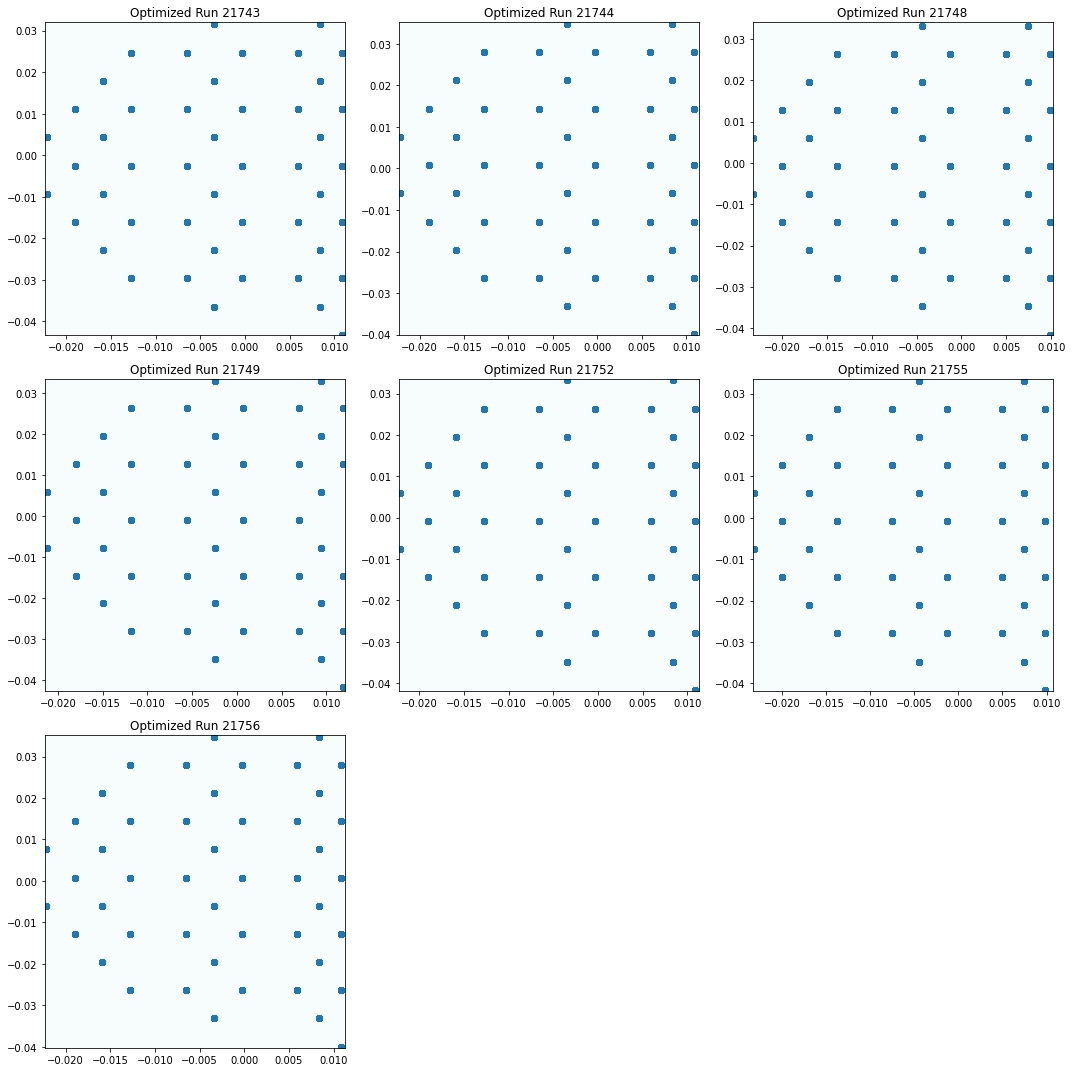

In [50]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=[15,15])
gs = gridspec.GridSpec(nrows=3, ncols=3, height_ratios=[1, 1, 1])

plotArr  = {gs[0,0]:21743, gs[0,1]:21744,gs[0,2]:21748,gs[1,0]:21749,gs[1,1]:21752,gs[1,2]:21755,gs[2,0]:21756}
subplot ={}


for key, runID in plotArr.items():
    currentdata = fulldata[fulldata.runID.eq(runID)]
    subplot[runID] =fig.add_subplot(key)
    subplot[runID].hist2d(currentdata['predicted_phi'],currentdata['predicted_theta'],bins=300,cmap=plt.cm.BuPu)
    subplot[runID].scatter(currentdata['targCalPh'],currentdata['targCalTh'])
    subplot[runID].set_title("Optimized Run {}".format(runID))

plt.tight_layout()
plt.show()

## Save  the model

In [51]:
runList = dataInitial['runID'].unique()

for currentrun in runList:
    currentdata = fulldata[fulldata.runID.eq(currentrun)]
    currentdata.to_csv("../result/trainRes_run_{}.csv".format(currentrun),index=False)